First set up generic Python/iPython for inline plots and common packages

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy

OK, let's do a nonlinear fit. First we will make some simulated data to fit. To start, define a function that generates a Gaussian, given specifed input parameters (how many?). It will be easier to generalize your fitting routine for any function if you consider the parameters as an input array. You can also write it so that the function will return a vector (array) of values if you specify an array of input values.

In [9]:
def gaussfunc(x, pars) :
    ''' A simple Gaussian function '''
    return  ...


How might you test your routine? Choose some sample values. Do both single values and array input.

In [29]:
print gaussfunc(...,...)

[  6.0653066  10.       ]


OK, let's generate some fake data, with n pts and uncertainties of sigma on each point.

<Container object of 3 artists>

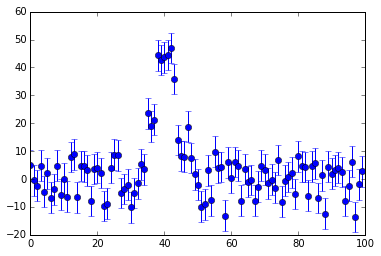

In [12]:
# get n samples with homoschedastic errors
n=....
pars=[...]
sig=...

# generate data arrays
sigma=sig+np.zeros(100)
x=np.arange(n)
# get the y values with gaussian errors
y=gaussfunc(x,pars)+np.random.normal(0.,sigma,n)

# plot it up
plt.clf()
plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')

OK, now we have to try to derive the parameters from the data set. Review how this is done: iteratively using matrix equations presented in class and in Numerical recipes. To do this, we will need to calculate the derivatives of the function with respect to each parameter. 

Write these down on paper.

For a general implemention, it will be most convenient, as above, to return the derivatives in an array. Note that you can make the routine work for input vectors of data to return vectors of derivatives.

In [21]:
def deriv(x,pars) :
 
    return np.array([...])

OK, now we want to do the fit. We will start with some guess of parameters (look at your plot to choose a good set).

Then we will iterate, calculating a correction at each iteration.

In [1]:
#initial guess
pars=[...]

# set up arrays
npar=...
alpha=np.zeros([npar,npar])
beta=np.zeros(npar)

plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')

# iterate. Really, we should iterate until convergence rather than a fixed number of iterations
for iter in range(10) :
    print 'Iter', iter
    print pars
    plt.plot(x,gaussfunc(x,pars))
    
    # loop over parameters, sums over data points are done with np.sum since x, y are vectors 
    for k in np.arange(npar) :
        # calculate beta array
        beta[k] = ...
        # calculate alpha array
        for j in np.arange(npar) :
            alpha[k,j] = ...
    # invert the matrix
    c=np.linalg.inv(alpha)
    # calculate correction vector and apply it to current parameters
    deltapars = np.dot(c,beta)
    pars += deltapars
                         

SyntaxError: invalid syntax (<ipython-input-1-45588a907c54>, line 2)

Modify the code to implement a convergence criterion, which can either be a maximum percent change in chi^2, or a maximum percent change in any of the parameters.

What are the calculated uncertainties on the parameters?

In [3]:
for i in npar :
    print pars[i], ...

SyntaxError: invalid syntax (<ipython-input-3-f703909167f1>, line 2)

OK, now let's implement it using the canned astropy routines

Model: Gaussian1D
Inputs: (u'x',)
Outputs: (u'y',)
Model set size: 1
Parameters:
      amplitude       mean         stddev   
    ------------- ------------ -------------
    47.1606830359 40.153533682 3.19564468726
[ 47.16068304  40.15353368   3.19564469]


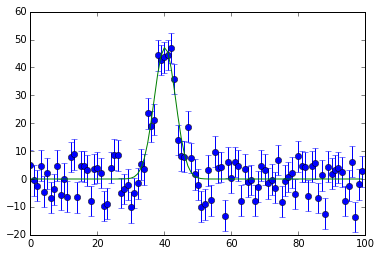

In [34]:
from astropy.modeling import models, fitting
fit_p = fitting.LevMarLSQFitter()
p_init = models.Gaussian1D(amplitude=...,mean=...,stddev=...)
pfit = fit_p(p_init,x,y)
print pfit
print pfit.parameters
# plot it up
plt.errorbar(x,y,yerr=sigma,marker='o',linestyle='none')
# pfit(x) evaluates the fit at locations x
plt.plot(x,pfit(x))
plt.draw()

See what happens when you try different starting guesses. How about different data parameters, e.g. sigma?

OK, let's do a Monte Carlo to get distribution of uncertainties

<type 'numpy.ndarray'>
<type 'numpy.ndarray'>


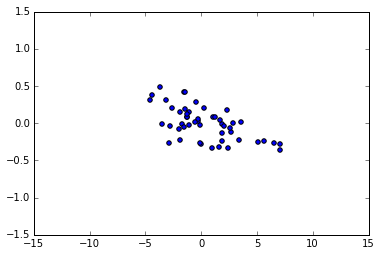

In [37]:
# let's build up arrays of differences between output and input parameters, and array of output parameters for multiple
# simulated data sets

diff=[]
out=[]
for sim in range(50) :
    test=gaussfunc(x,pfit.parameters)+np.random.normal(0.,sigma,n)
    simfit = fit_p(p_init,x,test)
    diff.append(simfit.parameters-pfit.parameters)
    out.append(simfit.parameters)
 
# Turn them into arrays for plotting
diff=np.array(diff)
out=np.array(out)

plt.scatter(diff[:,0],diff[:,2])
plt.xlim([-15,15])
plt.ylim([-1.5,1.5])
print type(out)
print type(diff)


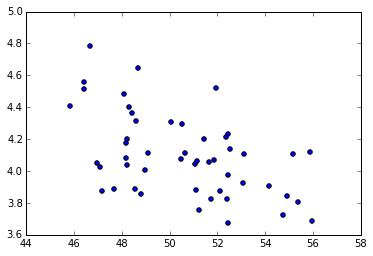

In [65]:
plt.scatter(out[:,0],out[:,2])

OK now let's do a bootstrap resampling from original sample

(-2.5, 2.5)

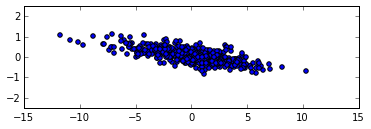

In [66]:
diff=[]
for sim in range(500) :
    resample_i = np.floor(np.random.rand(n)*len(x)).astype(int)
    x_resample = x[resample_i]
    y_resample = y[resample_i]
    simfit = fit_p(p_init,x_resample,y_resample)
    diff.append(simfit.parameters-pfit.parameters)
 
diff=np.array(diff)
diff.shape

plt.subplot(211)
plt.scatter(diff[:,0],diff[:,2])
plt.xlim([-15,15])
plt.ylim([-2.5,2.5])




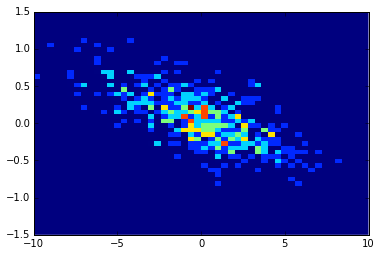

In [67]:
#histogram definition
xmin=-10
xmax=10
ymin=-1.5
ymax=1.5
xyrange = [[ymin,ymax],[xmin,xmax]] # data range
bins = [50,50] # number of bins

plt.xlim([xmin,xmax])
plt.ylim([ymin,ymax])

# histogram the data
plt.subplot(111)
hh, locx, locy = scipy.histogram2d(diff[:,2], diff[:,0], range=xyrange, bins=bins)
plt.imshow(hh,interpolation='none',extent=(xmin,xmax,ymin,ymax),origin='lower',aspect='auto')


OK, here's an attempt at a downhill simplex (Nelder-Mead) solution, where we will be minimizing chi^2

In [128]:
def chifunc(a,x,y,sigma) :
    ''' Chi^2 simple Gaussian function '''
    f=np.sum((y - (a[0] * np.exp(-0.5 * (x-a[1])**2/a[2]**2)))**2 / sigma**2 ) 
    return f
    
from scipy import optimize
pars = optimize.fmin(chifunc,x0=[60.,30.,10.],args=(x,y,sigma),retall=False,xtol=1.e-7)

print pars

#for i in pars[1] :
#    print i




Optimization terminated successfully.
         Current function value: 95.103710
         Iterations: 128
         Function evaluations: 239
[ 50.72367821  33.15385721   3.90050849]
